In [75]:
import numpy as np
import networkx as nx
import numpy.random as rnd
import string
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

def tnc(data):
    """ To Normal Coordinates"""
    if len(data.shape) > 1:
        data = data[:,1],data[:,0],data[:,2]
    else:
        data = data[1],data[0],data[2]
    return data

def plot(data):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(*tnc(data), marker='o')
    plt.show()

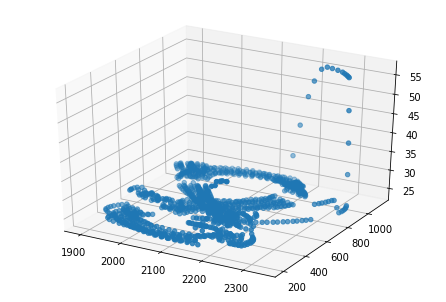

In [77]:
matX = np.genfromtxt('../data/q3dm1-path2.csv',delimiter=',')
plot(matX)

## task 17.1: SOMs of peculiar topology

In [68]:
def initRingSOM(matX, neurons, start=1):
    G = nx.generators.lattice.grid_2d_graph(neurons, start, periodic=True)
    G = nx.convert_node_labels_to_integers(G)
    m, n = matX.shape
    smpl = rnd.choice(m, neurons, replace=False)
    for i, v in enumerate(G):
        G.nodes[v]['w'] = matX[smpl[i],:]
    return G

def initGlasses(matX, neurons=20):
    assert neurons % 2 == 0, "k=%r invalid, the number of neurons can only be even" % k
    half_neurons = neurons // 2
    G1 = initRingSOM(matX, half_neurons)
    G2 = initRingSOM(matX, half_neurons)
    G = nx.disjoint_union(G1,G2)
    G.add_edge(half_neurons-1, half_neurons)
    return G

def trainSOM(matX, G, tmax=1000, sigma0=1., eta0=1.):
    m, n = matX.shape
    # compute matrix of squared path length distances between neurons
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    #
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    # a list of tmax random indices into the columns of matrix X
    smpl = rnd.randint(0, m, size=tmax)
    for t in range(tmax):
        # sample a point x, i.e. a row of matrix X
        vecX = matX[smpl[t],:]
        # determine the best matching unit
        b = np.argmin([np.sum((G.nodes[v]['w'] - vecX)**2) for v in G])
        # update the learning rate
        eta = eta0 * (1. - t/tmax)
        # update the topological adaption rate
        sigma = sigma0 * np.exp(-t/tmax)
        # update all weights
        for i, v in enumerate(G):
            # evaluate neighborhood function
            h = np.exp(-0.5 * matD[b,i] / sigma**2)
            G.nodes[v]['w'] += eta * h * (vecX - G.nodes[v]['w'])
    return G

In [69]:
G = initGlasses(matX, 24)
SOM1 = trainSOM(matX, G, tmax=10000)

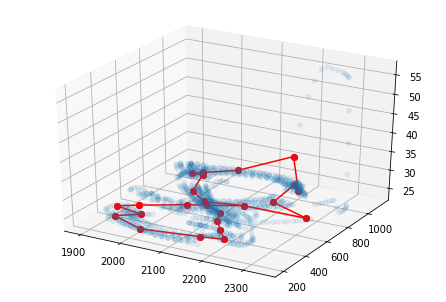

In [78]:
def plot_SOM_on_data(data, graph, SOM_color='red', data_color=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(*tnc(data), color=data_color, alpha=0.1)
    for u, v in graph.edges():
        dot1 = tnc(graph.nodes[u]['w'])
        dot2 = tnc(graph.nodes[v]['w'])
        edge = np.array([dot1, dot2]).T
        ax.plot(*edge, '-o', color=SOM_color)
    plt.show()

plot_SOM_on_data(matX, SOM1)

## task 17.2: SOM batch training

In [71]:
def batch_trainSOM(matX, G, tmax=1000, b_size=50, sigma0=1., eta0=1.):
    m, n = matX.shape
    # compute matrix of squared path length distances between neurons
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    #
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    # a list of tmax random indices into the columns of matrix X
    smpl = rnd.randint(0, m, size=tmax)
    for t in range(int(tmax//b_size)):
        # Create H matrix
        h_batch = np.zeros((b_size,len(G)))
        
        ## Batch compute
        for batch in range(b_size):
            # get index
            idx = t*b_size + batch
            # sample a point x, i.e. a row of matrix X
            vecX = matX[smpl[idx],:]
            # determine the best matching unit
            b = np.argmin([np.sum((G.nodes[v]['w'] - vecX)**2) for v in G])
            # update the topological adaption rate
            sigma = sigma0 * np.exp(-idx/tmax)

            # compute all h
            for i, v in enumerate(G):
                # evaluate neighborhood function
                h = np.exp(-0.5 * matD[b,i] / sigma**2)
                h_batch[batch,i] =  h
    
        ## Batch update
        vecXs = matX[smpl[t*b_size: t*b_size + b_size],:]
        # update all weights
        for i, v in enumerate(G):
            num = np.sum(vecXs * np.array([h_batch[:,i]]).T, axis=0)
            G.nodes[v]['w'] = num / np.sum(h_batch[:,i])

    return G

In [72]:
SOM1 = batch_trainSOM(matX, G, tmax=50000, b_size=50)

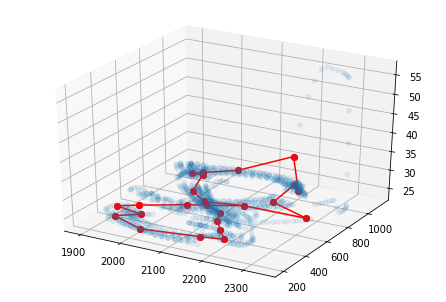

In [79]:
def plot_SOM_on_data(data, graph, SOM_color='red', data_color=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(*tnc(data), color=data_color, alpha=0.1)
    for u, v in graph.edges():
        dot1 = tnc(graph.nodes[u]['w'])
        dot2 = tnc(graph.nodes[v]['w'])
        edge = np.array([dot1, dot2]).T
        ax.plot(*edge, '-o', color=SOM_color)
    plt.show()

plot_SOM_on_data(matX, SOM1)

## task EXTRA: Wheel graph

In [83]:
def initWheel(matX, neurons=20):
    assert neurons % 2 == 0, "k=%r invalid, the number of neurons can only be even" % k
    half_neurons = neurons // 2
    G1 = initRingSOM(matX, half_neurons)
    G2 = initRingSOM(matX, half_neurons)
    G = nx.disjoint_union(G1,G2)

    for i in range(half_neurons):
        j = half_neurons + i
        G.add_edge(i, j)

    return G

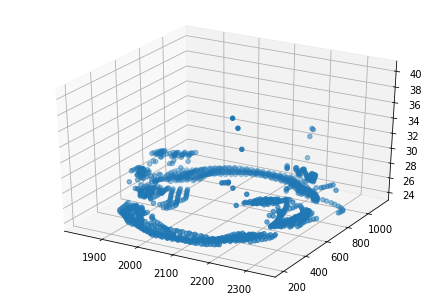

In [88]:
matX = np.genfromtxt('../data/q3dm1-path1.csv',delimiter=',')
plot(matX)

In [101]:
G = initWheel(matX)
SOM1 = trainSOM(matX, G, tmax=10000)

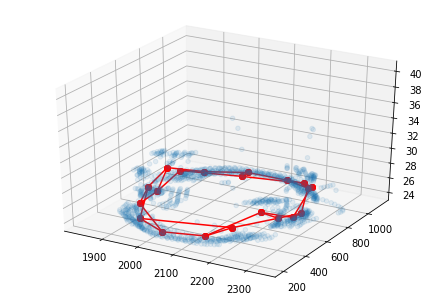

In [103]:
def plot_SOM_on_data(data, graph, SOM_color='red', data_color=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(*tnc(data), color=data_color, alpha=0.1)
    for u, v in graph.edges():
        dot1 = tnc(graph.nodes[u]['w'])
        dot2 = tnc(graph.nodes[v]['w'])
        edge = np.array([dot1, dot2]).T
        ax.plot(*edge, '-o', color=SOM_color)
    plt.show()

plot_SOM_on_data(matX, SOM1)